

# Analyse et Prédiction de la Consommation Énergétique d'un Bâtiment : Décomposition Saisonnale et Modélisation LSTM

## Première partie:### Objectif:

    L'objectif de cette première partie est de comprendre la structure de la consommation énergétique d'un bâtiment à travers des données simulées collectées sur une période de quatre ans, avec une fréquence quotidienne. Nous allons : Visualiser la consommation énergétique dans le temps, Analyser les tendances, les composantes saisonnières, et les résidus pour mieux comprendre les variations de la consommation

In [20]:
import pandas as pd

data = pd.read_csv ('Exercice 02- energy_consumption_dataset.csv')
print(data.head())

         Date  Energy Consumption
0  2020-01-01          305.311409
1  2020-01-02          299.374329
2  2020-01-03          307.646359
3  2020-01-04          316.811967
4  2020-01-05          299.651923


Text(0, 0.5, 'Consommation énergétique')

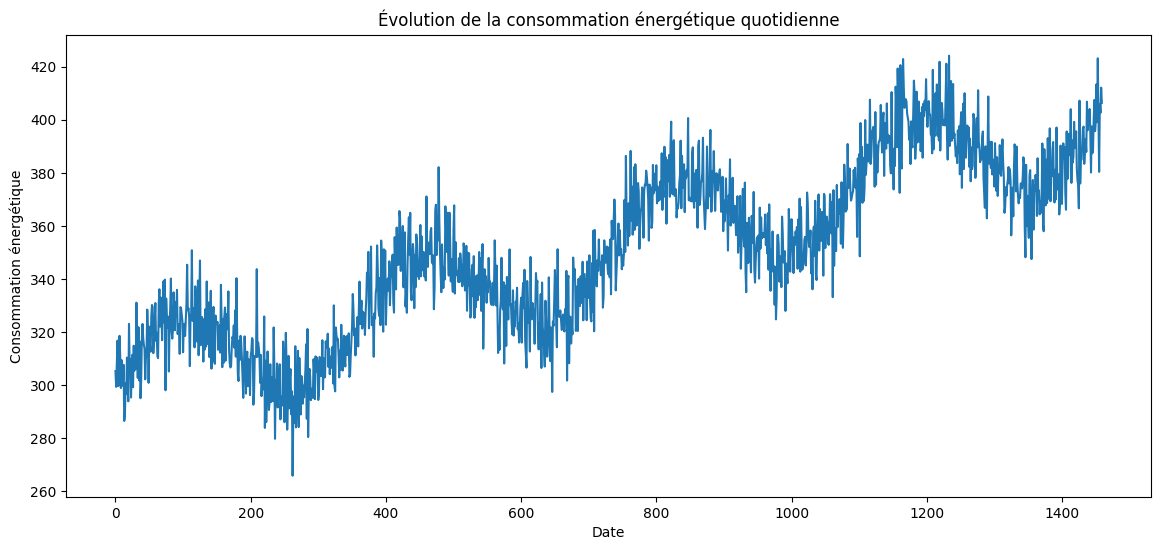

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data['Energy Consumption'], label='Daily Energy Consumption')
plt.title('Évolution de la consommation énergétique quotidienne')
plt.xlabel('Date')
plt.ylabel('Consommation énergétique')

### 1. Consommation énergétique :

    Il représente la consommation énergétique réelle jour après jour. 


Text(0, 0.5, 'Consommation')

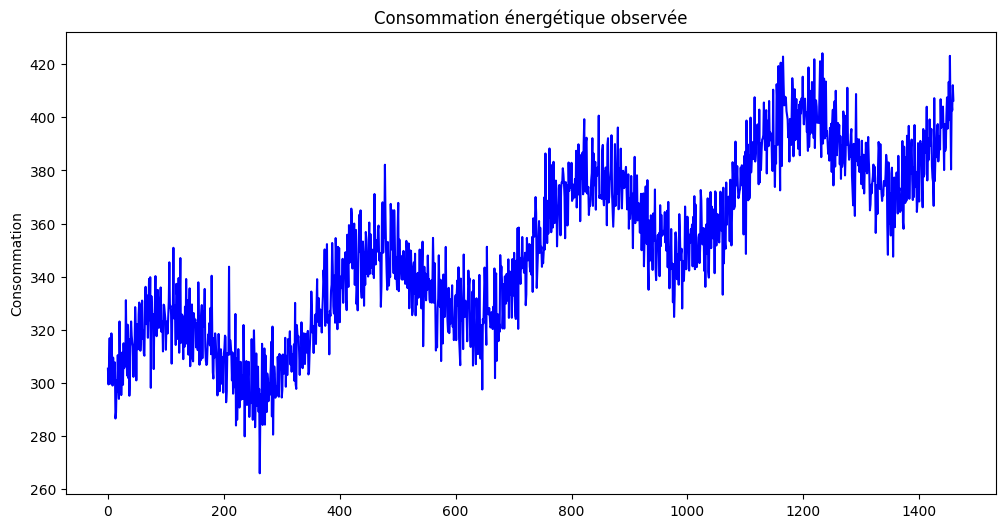

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(data['Energy Consumption'], model='additive', period=365)

plt.plot(decomposition.observed, label='Observed', color='blue')
plt.title("Consommation énergétique observée")
plt.ylabel('Consommation')

    On remarque des fluctuations régulières ainsi qu'une tendance générale légèrement croissante. Il y a des cycles répétitifs, ce qui suggère un schéma saisonnier sous-jacent.


### 2. Tendance (Trend) :

    Cette composante montre la tendance à long terme de la consommation énergétique (par exemple, une augmentation ou une diminution générale au fil des ans).


Text(0, 0.5, 'Tendance')

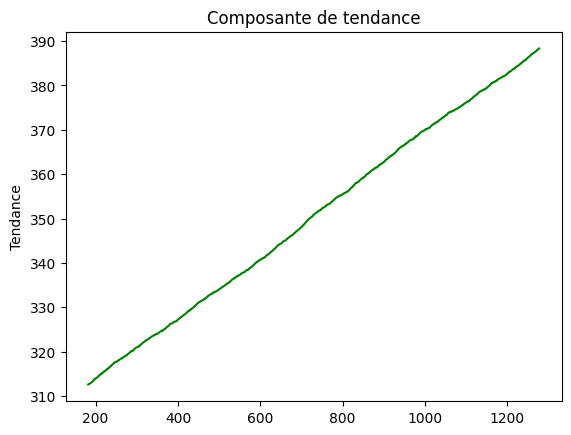

In [22]:
plt.plot(decomposition.trend, label='Trend', color='green')
plt.title("Composante de tendance")
plt.ylabel('Tendance')

    La tendance est globalement croissante. Cela pourrait signifier que la consommation énergétique du bâtiment augmente progressivement au fil du temps. Il peut y avoir plusieurs raisons : une intensification de l'utilisation du bâtiment ou une augmentation des besoins énergétiques.



### 3. Saisonnalité (Seasonality) :

    Cela montre les variations périodiques récurrentes (par exemple, une hausse de la consommation en hiver si du chauffage est utilisé). Elle illustre les motifs saisonniers qui influencent les données.


Text(0, 0.5, 'Saisonnalité')

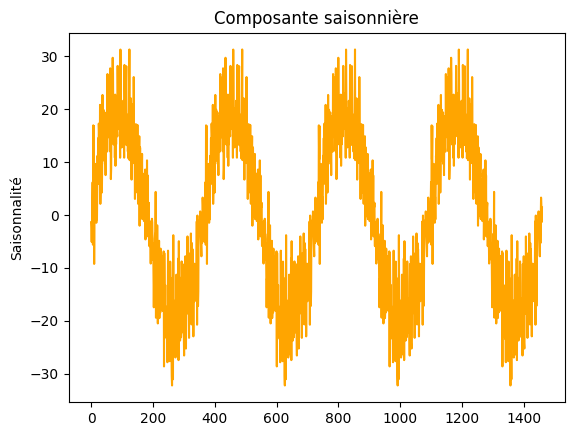

In [23]:
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.title("Composante saisonnière")
plt.ylabel('Saisonnalité')

    On observe des cycles périodiques bien marqués, indiquant que la consommation énergétique varie régulièrement en fonction des saisons. 
    Par exemple :
     - Les pics de consommation peuvent correspondre aux périodes hivernales où le chauffage est utilisé plus intensivement.
     - Les creux pourraient correspondre aux périodes estivales ou lorsque les besoins énergétiques sont plus faibles.
    Cela souligne l’importance de la saisonnalité dans la gestion de l’énergie, où certaines périodes de l'année consomment plus d'énergie que d'autres



### 4. Résidus (Residuals) :

    Cette composante représente les variations restantes non expliquées par la tendance et la saisonnalité. Elle aide à identifier des anomalies ou des événements inattendus (ex. : pannes, pics anormaux).

Text(0, 0.5, 'Résidus')

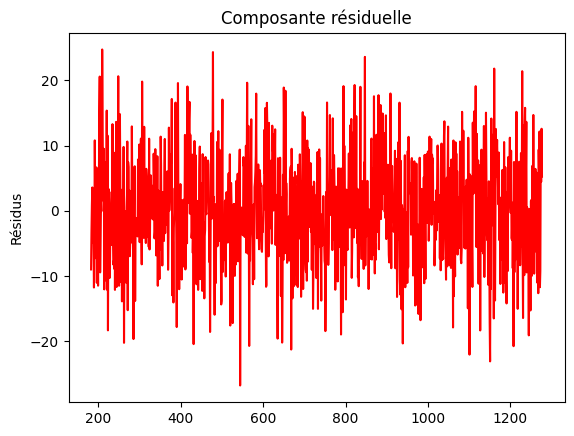

In [24]:
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title("Composante résiduelle")
plt.ylabel('Résidus')

        Les résidus sont assez aléatoires, ce qui signifie qu’ils représentent des anomalies ou des variations imprévisibles dans la consommation énergétique. Ces fluctuations peuvent être dues à des événements spécifiques, comme des pannes ou des interventions imprévues, des changements de température extrêmes, ou des pics d’utilisation imprévus.        Les résidus semblent relativement petits, ce qui indique que la majeure partie de la variabilité de la consommation énergétique est bien capturée par la tendance et la saisonnalité



### Calcul de la Consommation Mensuelle Moyenne :

In [40]:
data = pd.read_csv('Exercice 02- energy_consumption_dataset.csv', parse_dates=['Date'])
print(data.dtypes)

Date                  datetime64[ns]
Energy Consumption           float64
dtype: object


In [41]:
data.set_index('Date', inplace=True)
monthly_avg_consumption = data['Energy Consumption'].resample('M').mean()

Text(0, 0.5, 'Consommation énergétique moyenne')

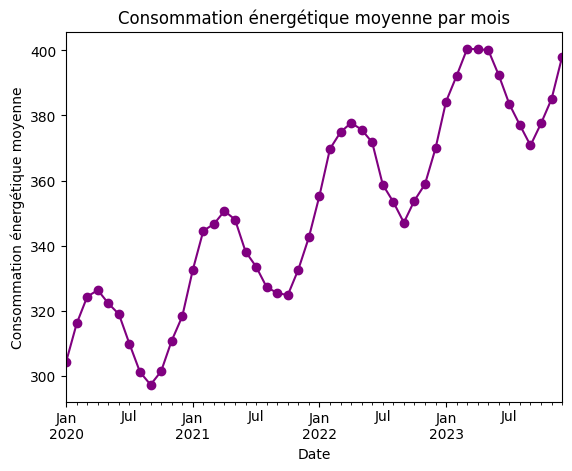

In [42]:
monthly_avg_consumption.plot(color='purple', marker='o', linestyle='-')
plt.title("Consommation énergétique moyenne par mois")
plt.xlabel("Date")
plt.ylabel("Consommation énergétique moyenne")

## Observation: 
    la consommation énergétique moyenne est en pic en avril, mars et mai, tandis qu'elle est plus faible en septembre et octobre.
### 1. Pic de Consommation (Mars, Avril, Mai) :

    Ces mois pourraient coïncider avec des températures de transition (fin de l’hiver et début du printemps) qui exigent un chauffage constant le matin et le soir, ou une climatisation occasionnelle, ce qui augmente la demande en énergie. Dans les bâtiments, cette période de transition peut aussi voir une utilisation accrue des systèmes de ventilation.

### 2. Creux de Consommation (Septembre, Octobre) :

    En septembre et octobre, les températures sont souvent plus modérées, nécessitant moins de chauffage et de climatisation. Les températures tempérées réduisent ainsi la demande énergétique pour maintenir un confort thermique, ce qui entraîne une consommation plus faible.

# préparation des données et implémentation du modèle LSTM

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

data = pd.read_csv ('Exercice 02- energy_consumption_dataset.csv')

data.columns = data.columns.str.strip()  # Pour enlever les espaces
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

### 1. Gestion des valeurs manquantes

In [4]:
print("Valeurs manquantes avant traitement:\n", data.isnull().sum())
data['Energy Consumption'].interpolate(method='linear', inplace=True)
print("Valeurs manquantes après traitement:\n", data.isnull().sum())

Valeurs manquantes avant traitement:
 Energy Consumption    0
dtype: int64
Valeurs manquantes après traitement:
 Energy Consumption    0
dtype: int64


### 2. Normalisation des données de consommation

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['Energy Consumption'] = scaler.fit_transform(data['Energy Consumption'].values.reshape(-1, 1))

### 3. Création des séquences pour LSTM

In [6]:
sequence_length = 30  
X, y = [], []

for i in range(sequence_length, len(data)):
    X.append(data['Energy Consumption'].values[i-sequence_length:i])
    y.append(data['Energy Consumption'].values[i])

X, y = np.array(X), np.array(y)

### 4. Division des données en ensemble d'apprentissage et de test

In [7]:
split_ratio = 0.8
train_size = int(len(X) * split_ratio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### 5. Création du modèle LSTM

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 6. Entraînement du modèle et prédiction

In [9]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
predicted = model.predict(X_test)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.1172 - val_loss: 0.0048
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0092 - val_loss: 0.0077
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0067 - val_loss: 0.0043
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0070 - val_loss: 0.0045
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0070 - val_loss: 0.0045
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0062 - val_loss: 0.0047
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0068 - val_loss: 0.0045
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0

### 7. Inverser la normalisation pour obtenir les valeurs réelles

In [10]:
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

### Visualisation des résultats

Text(0, 0.5, 'Consommation Énergétique')

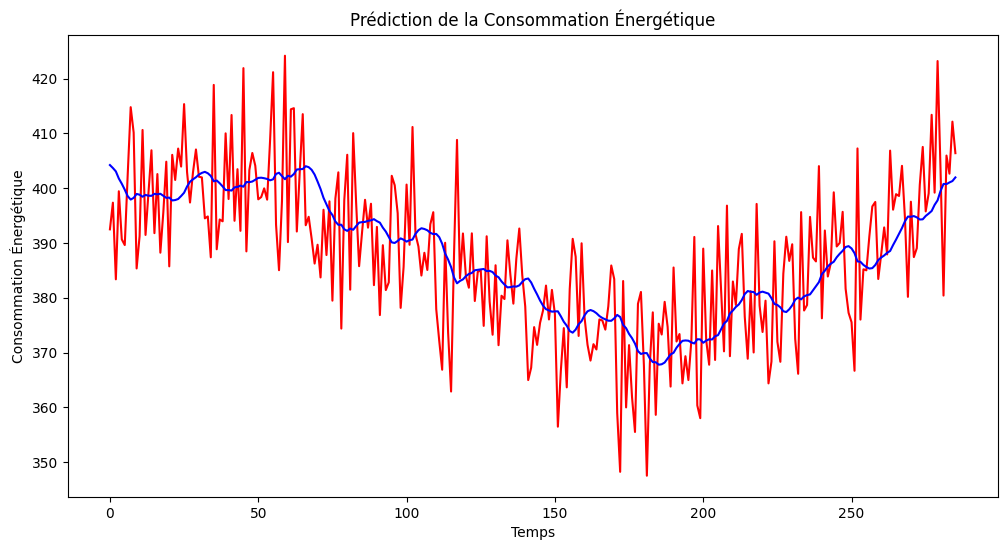

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, color='red', label='Valeurs Réelles')
plt.plot(predicted, color='blue', label='Prédictions')
plt.title('Prédiction de la Consommation Énergétique')
plt.xlabel('Temps')
plt.ylabel('Consommation Énergétique')

## Analyse de l'Impact du Nombre de Neurones dans la Prédiction de la Consommation Énergétique

In [15]:
neuron_configs = [20, 50, 100]
for neurons in neuron_configs:
    model = Sequential()
    model.add(LSTM(units=neurons, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=neurons))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1)
    # Code pour enregistrer et visualiser les métriques ici


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.1546 - val_loss: 0.0229
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0150 - val_loss: 0.0057
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0097 - val_loss: 0.0044
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0105 - val_loss: 0.0048
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0099 - val_loss: 0.0044
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0085 - val_loss: 0.0044
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0088 - val_loss: 0.0053
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0084 - val_loss: 0.0049
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.1085 - val_loss: 0.0056
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.007

## Implémentation de Modèles BI-LSTM et GRU pour la Prévision de la Consommation Énergétique

In [14]:
from tensorflow.keras.layers import Bidirectional, GRU

# BI-LSTM
bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X.shape[1], 1)))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Bidirectional(LSTM(50)))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Dense(1))
bi_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
bi_lstm_model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1)

# GRU
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X.shape[1], 1)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(50))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1)


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0885 - val_loss: 0.0105
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0073 - val_loss: 0.0057
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0068 - val_loss: 0.0047
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0061 - val_loss: 0.0077
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0065 - val_loss: 0.0046
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0060 - val_loss: 0.0092
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0909 - val_loss: 0.0047
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.01